# An Intro to Practical Data Science

**Practical data science (my definition)**: Solving data problems.

Why so broad?  Because data in general is incredibly diverse, and so the related problems are as well.  Examples of **data problems**:

 - a small business needs to keep track of their customer base and marketing campaigns
 - foreign aid workers need to map out a constantly-shifting landscape of supplies and tents in a refugee camp
 - a bank needs to model how likely lenders are to repay their loans
 - doctors need to detect tumors from MRI results
 
And **solutions**:

 - a dashboard linked to an e-commerce system
 - a network of connected Internet of Things devices, with locations visualized on a map
 - a model predicting risk and return for a given lender
 - a neural network identifying tumors in images
 
And **practical concerns**:

 - how to implement a dashboard and integrate it with existing systems in a maintainable way?
 - how to best purchase, program, and deliver hardware en masse?
 - how much personal information can/should be used in modeling user behavior?  how to store and safeguard that information?
 - how to most efficiently train an extremely complex model using distributed computing resources?
 
As a data scientist, you may encounter one or more of these problems, solutions, and practical issues.  It's extremely important to understand that data science isn't just building models -- in fact, that's only a tiny part of it.  The majority of the time in almost every data science project is spent doing one or more of the following unglamorous tasks:

 - obtaining, cleaning, and managing data
 - building software/hardware applications
 - evaluating results with respect to multiple (often competing) priorities
 - designing the most effective way to present results to stakeholders and/or users

## A Practical Problem

It's unrealistic to walk through the whole data cleaning process or a software development cycle in an intro notebook, so I'll instead be presenting a practical problem you might try to solve with data science techniques and describe some of the real-world issues you may encounter in the process.

We'll be looking at traffic stops in North Carolina using data provided by [Open Data Policing](https://opendatapolicing.com/nc/).  We'd like to determine whether a traffic stop results in the driver being searched.  I've already wrangled the data into a simple modeling dataset (and reduced the size to a week's worth of data, for the sake of demonstration); you can see the gory details in [the Github repo](https://github.com/jasonnance/ds-intro-traffic-stops) if you're curious.  The dataset contains a row for each traffic stop and includes some information about the circumstances as well as whether the driver was searched.

Each time you see a **Question**, take a minute to answer before scrolling further.

---

**Question**: If you had a model to predict whether a search would be performed, given the circumstances of a traffic stop, what could you do with it?

In [2]:
# Turn on the magic
%matplotlib inline
# Import necessary modules
import pandas as pd

In [3]:
# Read in and inspect the data
data = pd.read_csv("./traffic_stops_nc.csv.xz")
data.head()

,agency,purpose,driver_gender,driver_age,driver_ethnicity,driver_race,driver_searched
0,Matthews Police Department,Vehicle Regulatory Violation,Female,22,Hispanic,White,f
1,Orange County Sheriff's Office,Vehicle Regulatory Violation,Female,20,Non-Hispanic,White,f
2,Lee County Sheriff's Office,Vehicle Regulatory Violation,Female,40,Non-Hispanic,White,t
3,Fletcher Police Department,Vehicle Regulatory Violation,Female,23,Hispanic,White,f
4,Surry County Sheriff's Office,Safe Movement Violation,Male,18,Non-Hispanic,White,f


A little touching up is necessary:

In [4]:
# Convert string 't' and 'f' to boolean representation
data['driver_searched'] = data['driver_searched'].apply(lambda x: True if x == 't' else False)
data.head()

,agency,purpose,driver_gender,driver_age,driver_ethnicity,driver_race,driver_searched
0,Matthews Police Department,Vehicle Regulatory Violation,Female,22,Hispanic,White,False
1,Orange County Sheriff's Office,Vehicle Regulatory Violation,Female,20,Non-Hispanic,White,False
2,Lee County Sheriff's Office,Vehicle Regulatory Violation,Female,40,Non-Hispanic,White,True
3,Fletcher Police Department,Vehicle Regulatory Violation,Female,23,Hispanic,White,False
4,Surry County Sheriff's Office,Safe Movement Violation,Male,18,Non-Hispanic,White,False


## Exploration

Real data has real quirks (and often real errors...).  It always pays to look around a bit before diving into a model.

---

**Question**: What should we check about the data before attempting to build a model?

In [5]:
# Probably the size of the dataset
print("{} rows and {} columns".format(*data.shape))

31384 rows and 7 columns


In [6]:
# Maybe the distribution of values in a categorical column?
data['purpose'].value_counts()

Speed Limit Violation            14758
Vehicle Regulatory Violation      6161
Vehicle Equipment Violation       2850
Safe Movement Violation           1749
Investigation                     1416
Stop Light/Sign Violation         1414
Seat Belt Violation               1390
Other Motor Vehicle Violation     1004
Checkpoint                         517
Driving While Impaired             125
Name: purpose, dtype: int64

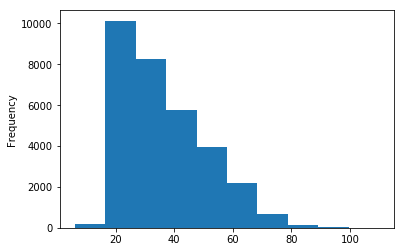

In [7]:
# Maybe the distribution of values in a numeric column?
# Watch out for outliers/data errors...
data['driver_age'].plot(kind='hist')

In [8]:
# Most definitely the distribution of the target variable
data['driver_searched'].value_counts(normalize=True)

False    0.976612
True     0.023388
Name: driver_searched, dtype: float64

**Question**: What are some possible implications of the target variable being so imbalanced?

## Building a Model

We finally made it to the fun part.  We're going to use a decision tree, which learns a series of decision rules based on the patterns present in a dataset.  They can be used on all types of data (continuous, categorical, etc) and both classification and regression problems.  They can also be combined into powerful ensembles called random forests, although we'll stick with simple decision trees for this problem.

Decision trees are a good fit for this case study for the following reasons:

 - Decision trees are extremely easy to interpret, so our model's decisions will be very transparent
 - Decision trees can be very easily and usefully visualized, which makes it even easier for us to see what a given model is doing
 - Decision trees train very quickly (nearly instantly on this small dataset), so we can iterate on model parameters very quickly

First, we need to build the dataset.

---

**Question**: What are some of the pros and cons of using a decision tree in general?

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [10]:
# Standard dummy variable creation, train/test split, and numpy-fication
def do_train_test_split(data):
    model_data = pd.get_dummies(data[['agency', 'purpose', 'driver_gender',
                                      'driver_ethnicity', 'driver_race']])
    X = model_data
    y = data['driver_searched']
    
    return train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


X_train, X_test, y_train, y_test = do_train_test_split(data)
print(X_train.shape, X_test.shape)

(25107, 226) (6277, 226)


Now that we have the dataset, we can build the model.

In [41]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import SVG, display
from graphviz import Source

In [48]:
# Print a customized classification report
def search_classification_report(y_test, y_pred):
    return classification_report(y_test, y_pred, digits=4,
                                 target_names=['Not Searched', 'Searched'])

# Print a report based on the confusion matrix for the given predictions
def print_confusion_matrix(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("True Negatives (Predicted no search, actual no search): {}".format(tn))
    print("False Positives (Predicted search, actual no search): {}".format(fp))
    print("False Negatives (Predicted no search, actual search): {}".format(fn))
    print("True Positives (Predicted search, actual search): {}".format(tp))

# Print some performance metrics and display the trained tree
def evaluate_model(estimator, X_train, X_test, y_train, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    
    print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
    print(search_classification_report(y_test, y_pred))
    print_confusion_matrix(y_test, y_pred)
    
    graph = Source(export_graphviz(estimator, out_file=None,
                                   feature_names=X_train.columns,
                                   class_names=['Not Searched', 'Searched'],
                                   filled=True,
                                   impurity=False))
    display(SVG(graph.pipe(format='svg')))
    return model

Scikit-learn's DecisionTreeClassifier has a bunch of knobs we can tweak.  Here are some relevant bits from the [scikit-learn documentation for DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier):

- **criterion : string, optional (default=”gini”)**: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
- **max_depth : int or None, optional (default=None)**: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **min_samples_split : int, float, optional (default=2)**: The minimum number of samples required to split an internal node.
- **min_samples_leaf : int, float, optional (default=1)**: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- **min_weight_fraction_leaf : float, optional (default=0.)**: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
- **max_leaf_nodes : int or None, optional (default=None)**: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- **min_impurity_decrease : float, optional (default=0.)**: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

**BIG NO-NO ALERT**: For the sake of training time, we're evaluating our parameters on the test set.  On a real problem, you would _never ever_ do this, since it biases you toward picking hyperparameters that favor the nuances of your test set rather than being generalizable.  _Always_ use a separate validation set to evaluate your hyperparameters; **preferably** use cross-validation.

Accuracy: 0.6393181456109607
              precision    recall  f1-score   support

Not Searched     0.9921    0.6357    0.7749      6130
    Searched     0.0494    0.7891    0.0929       147

   micro avg     0.6393    0.6393    0.6393      6277
   macro avg     0.5207    0.7124    0.4339      6277
weighted avg     0.9700    0.6393    0.7589      6277

True Negatives (Predicted no search, actual no search): 3897
False Positives (Predicted search, actual no search): 2233
False Negatives (Predicted no search, actual search): 31
True Positives (Predicted search, actual search): 116


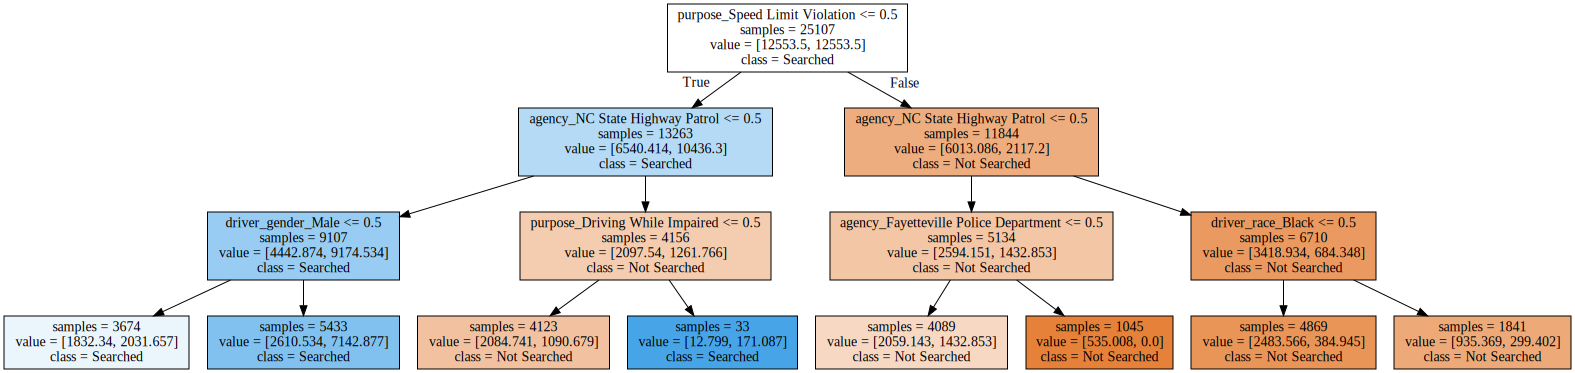

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0, presort=False, random_state=1,
            splitter='best')

In [49]:
model = DecisionTreeClassifier(
    # Change these hyperparameters to your heart's content
    criterion="gini",
    # Beware setting max_depth to much larger than 5 or 10 --
    # you may crash your browser when it tries to draw the tree!
    max_depth=3,  
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0,
    max_leaf_nodes=None,
    min_impurity_decrease=0,
    
    # Don't change anything down here
    random_state=1,
    class_weight='balanced'
)

evaluate_model(model, X_train, X_test, y_train, y_test)

**Question**: Can you improve on the model performance by changing any of the parameters?

## A Question of Bias

Now, let's jump out of imaginary data science and into the real world.

A police agency faces accusations of bias when searching vehicles during traffic stops.  The community feels that officers are more likely to search vehicles with black drivers when they're pulled over.  In response, they decide to use your model to determine whether to search someone as they're being pulled over, in hopes of eliminating the potential human bias involved.

Naturally, you want to prevent your model from using race as a decision variable!  The easiest way to do that is to drop race and ethnicity from the model entirely.

...or is it?

Let's see what happens.  First, we create an "unbiased" dataset by dropping the potentially biased columns.

In [50]:
X_train, X_test, y_train, y_test = do_train_test_split(data)

# Drop the columns that could be used to inject racial bias into the model
bias_cols = [c for c in X_train.columns
             if c.startswith("driver_race_")
             or c.startswith("driver_ethnicity_")]
print("Dropping these bad columns:", bias_cols)
X_train_unbiased = X_train.drop(bias_cols, axis=1)
X_test_unbiased = X_test.drop(bias_cols, axis=1)

Dropping these bad columns: ['driver_ethnicity_Hispanic', 'driver_ethnicity_Non-Hispanic', 'driver_race_Asian', 'driver_race_Black', 'driver_race_Native American', 'driver_race_Other', 'driver_race_White']


Now, we re-train the model using our new dataset.

**Question**: How do your results look compared to the original model?  Did removing these variables make the model better or worse?

Accuracy: 0.6393181456109607
              precision    recall  f1-score   support

Not Searched     0.9921    0.6357    0.7749      6130
    Searched     0.0494    0.7891    0.0929       147

   micro avg     0.6393    0.6393    0.6393      6277
   macro avg     0.5207    0.7124    0.4339      6277
weighted avg     0.9700    0.6393    0.7589      6277

True Negatives (Predicted no search, actual no search): 3897
False Positives (Predicted search, actual no search): 2233
False Negatives (Predicted no search, actual search): 31
True Positives (Predicted search, actual search): 116


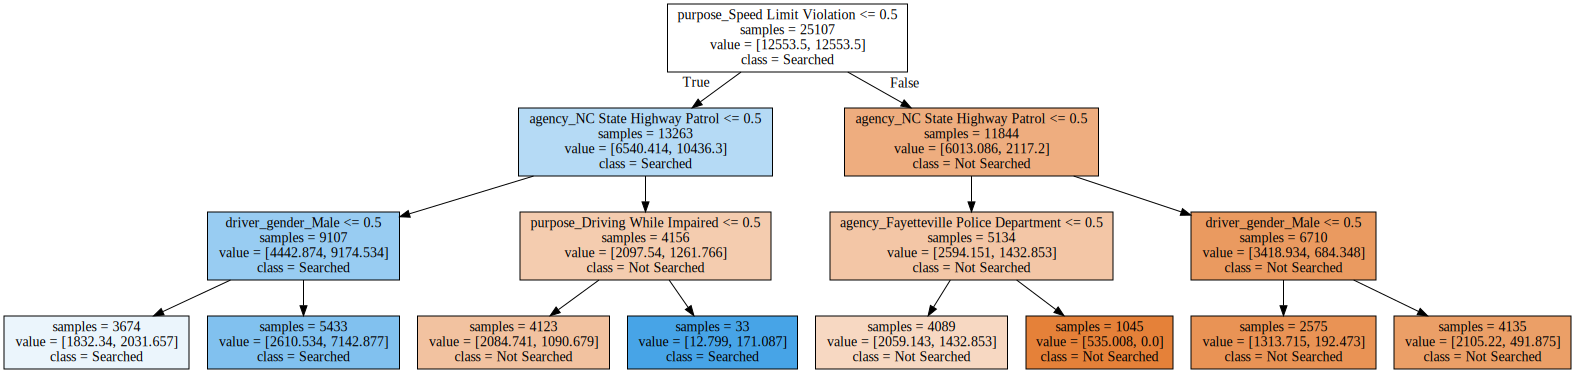

In [51]:
fit_model = evaluate_model(model, X_train_unbiased, X_test_unbiased, y_train, y_test)

Now, let's check to see if the model is still biased... just in case.  Let's look at the proportion of stops predicted to be searches for black vs non-black drivers.

In [52]:
X_test_unbiased_black_drivers = X_test_unbiased[X_test['driver_race_Black'] == 1]
X_test_unbiased_nonblack_drivers = X_test_unbiased[X_test['driver_race_Black'] == 0]

predictions_black_driver = pd.Series(fit_model.predict(X_test_unbiased_black_drivers))
predictions_nonblack_driver = pd.Series(fit_model.predict(X_test_unbiased_nonblack_drivers))

print("Proportion of stops predicted to be searches for black drivers (n={}):".format(
    predictions_black_driver.shape[0]))
display(predictions_black_driver.value_counts(normalize=True)[True])
print("Proportion of stops predicted to be searches for non-black drivers (n={}):".format(
    predictions_nonblack_driver.shape[0]))
display(predictions_nonblack_driver.value_counts(normalize=True)[True])

Proportion of stops predicted to be searches for black drivers (n=2176):


0.46047794117647056

Proportion of stops predicted to be searches for non-black drivers (n=4101):


0.3284564740307242

In my example model, even though we took out any race-related variables, the model is still predicting more searches for black than non-black drivers.  This could just be an artifact of our test dataset, though, if "race = black" just happens to be correlated with some other (non-racial) reason for increased searches.  It's only a problem for our model if it impacts our performance on black vs non-black drivers.  Does it?

In [54]:
y_actual_black_driver = y_test[X_test['driver_race_Black'] == 1]
y_actual_nonblack_driver = y_test[X_test['driver_race_Black'] == 0]

print("Model performance for black drivers:")
print(search_classification_report(y_actual_black_driver,
                                   predictions_black_driver))
print_confusion_matrix(y_actual_black_driver, predictions_black_driver)
print("---")
print("Model performance for non-black drivers:")
print(search_classification_report(y_actual_nonblack_driver,
                                   predictions_nonblack_driver))
print_confusion_matrix(y_actual_nonblack_driver, predictions_nonblack_driver)

Model performance for black drivers:
              precision    recall  f1-score   support

Not Searched     0.9864    0.5501    0.7063      2105
    Searched     0.0549    0.7746    0.1025        71

   micro avg     0.5574    0.5574    0.5574      2176
   macro avg     0.5206    0.6624    0.4044      2176
weighted avg     0.9560    0.5574    0.6866      2176

True Negatives (Predicted no search, actual no search): 1158
False Positives (Predicted search, actual no search): 947
False Negatives (Predicted no search, actual search): 16
True Positives (Predicted search, actual search): 55
---
Model performance for non-black drivers:
              precision    recall  f1-score   support

Not Searched     0.9946    0.6805    0.8081      4025
    Searched     0.0453    0.8026    0.0857        76

   micro avg     0.6828    0.6828    0.6828      4101
   macro avg     0.5199    0.7416    0.4469      4101
weighted avg     0.9770    0.6828    0.7947      4101

True Negatives (Predicted no search

It's clear that removing race from our model wasn't enough to solve the problem.

**Question**: How could our model's performance be affected by a variable it isn't even looking at?

## Aftermath

**DISCLAIMER**: I'm not in any way claiming that this dataset does or does not show evidence of racial bias in traffic stops and searches.  We haven't dug deeply enough to conclude anything.

As you can see, there's a lot of potential for data science to go horribly awry, even when we act with good intentions.

What can we do about it?

For this specific problem, we need to understand how and why race is related to the other variables in the model in order to account for it.  Is it an artifact of our dataset or data collection process?  Is there an underlying correlation?  Tools such as [Google's What-If Tool](https://pair-code.github.io/what-if-tool/) may be useful.

In general:

- Always consider your data science products (models, applications, etc) in context.  Talk to users and stakeholders -- what are _all_ the implications of your solution?
- Emphasize diversity in all aspects when building a data science team: gender, ethnicity, skills, and experience.
- Avoid siloing yourself in approaches or ways of thinking; keep an open mind to others' experiences.

Data science isn't all about building cool models, and conversely, it needs a lot more than people who build cool models.  I hope this has been a useful introduction to the underappreciated practical aspects of data science.

## Nerdy Footnotes

Some of the approaches used in this notebook were decidedly suboptimal for the sake of demonstration.  Here are some potential areas for improvement:

 - Use more data fields; the OpenDataPolicing traffic stop dataset is very rich and contains a ton of info that wasn't used here.  Try pulling some more of it in.
 - Use more data; to avoid freezing Binder, this notebook uses a tiny subset (1 week) of the real data (over a decade).
 - Try different models; decision trees aren't appropriate for solving every problem.  scikit-learn has [a lot of other choices](https://scikit-learn.org/stable/supervised_learning.html).
 - Use grid search and cross-validation to find hyperparameters in a structured way, rather than tweaking and evaluating against the test set.  Look into scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
 - scikit-learn also has some functionality that makes preprocessing much more reusable and easier to manage.  Check out [Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline).


And one final impassioned plea:

If you're writing complex preprocessing and model training routines, please consider writing plain old Python scripts instead of a massive web of Jupyter notebooks!  See [a detailed exploration of problems with keeping code in Jupyter notebooks](https://docs.google.com/presentation/d/1n2RlMdmv1p25Xy5thJUhkKGvjtV-dkAIsUXP-AL4ffI/edit).